# Exercise #1 - Measuring Relaxation in Qubits

In this exercise you will use the parameters we learned about our chip in the tutorial to learn about the relaxation rate (or $T_1$)

In [1]:
import sys
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

from qiskit import IBMQ, pulse
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import SchedStyle

if not sys.warnoptions:
    warnings.simplefilter("ignore")

style = SchedStyle(figsize=(6, 3), title_font_size=0, axis_font_size=12, label_font_size=0, icon_font_size=8, 
                   table_font_size=6, table_columns=1)

## First lets load our backend

In [2]:
hub = 'ibm-q-community'
group = 'ieee-session'
project = 'main'
backend_name = 'ibmq_rome'

In [3]:
from qiskit import IBMQ
# Load account credentials
IBMQ.load_account()
# Load provider
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
# Get our backend
backend = provider.get_backend(backend_name)

In [4]:
# configuration - Hardware configuration information.
config = backend.configuration()
# properties - Physical properties of the device.
properties = backend.properties()
# defaults - Information for pulse properties that change frequently.
defaults = backend.defaults()

Then we load our calibrated chip from the tutorial

In [5]:
from chip import Chip

chip = Chip.load('saved_chip_ex1.json')
chip

Chip(Qubit(0, attrs={'w0_1': 4968877654.085692, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.08726686228679852}), Qubit(1, attrs={'w0_1': 4770396310.6765375, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.06184223901695044}))

# Measuring  $𝑇_1$  using Inversion Recovery 
The $𝑇_1$  time of a qubit is the time it takes for a qubit to decay from the excited state to the ground state. It is important because it limits the duration of meaningful programs we can run on the quantum computer.

To measure the we $𝑇_1$ we ill uses the  𝜋  pulse we've calibrated. We again apply a single drive pulse, our  𝜋  pulse, then apply a measure pulse. However, this time we do not apply the measurement immediately. We insert a delay, and vary that delay between experiments. When we plot the measured signal against delay time, we will see a signal that decays exponentially as the qubit relaxes in energy. The decay time is the  $𝑇_1$ , or relaxation time, of the qubit!

The experiment consists of a few steps

1. Excite the qubit from $|0>$ to $|1>$
2. Wait for some period of time $\tau$ (There is a `pulse.delay` instruction)
3. Measure the excited state population
4. Repeat for a new value of $\tau$

![inversion recovery experiment](./inversion_recovery.png)

### First load your x180 pulse 

hint: it will be twice as much rotation as your x90 pulse you calibrated and stored.

In [6]:
# Solution
x180_pulses = []
for qubit in chip.qubits:
    x180 = pulse.Gaussian(qubit.attrs.x90_dur, qubit.attrs.x90_amp*2, qubit.attrs.x90_sigma)
    x180_pulses.append(x180)

### Now write the experiment described above for each qubit

If you're stuck the documentation for [pulse can be found here](https://qiskit.org/documentation/apidoc/pulse.html). The pulse builder documentation is at the [end of the page](https://qiskit.org/documentation/apidoc/pulse.html#pulse-builder-builder), you can always default to using the older `Schedule` interface presented in the [tutorials](https://qiskit.org/documentation/tutorials/pulse/index.html). 

In [7]:
d = lambda qubit: pulse.DriveChannel(qubit)
m = lambda qubit: pulse.MeasureChannel(qubit) 
a = lambda qubit: pulse.AcquireChannel(qubit)
mem_slot = lambda qubit: pulse.MemorySlot(qubit)

In [8]:
# Solution
n_exps = 50
min_delay = 0.
max_delay = 500.e-6
delays = np.linspace(min_delay, max_delay, n_exps)

exps = []
for delay in delays:
    with pulse.build(backend=backend) as exp:
        for i, qubit in enumerate(chip.qubits):
            # Stimulate qubit and delay
            # Remember the delay time has to be converted to
            # samples.
            pulse.play(x180_pulses[i], d(qubit.index))
            pulse.delay(pulse.seconds_to_samples(delay), d(qubit.index))
        # Measure qubits
        # Don't forget to apply your measurement after
        # your stimulus (use a barrier)
        pulse.barrier(*[qubit.index for qubit in chip.qubits])
        pulse.measure_all()
    
    exps.append(exp)

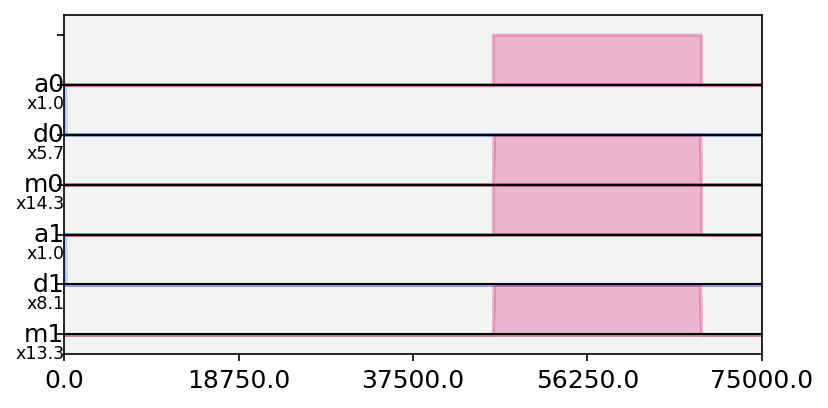

In [9]:
channels_to_plot = [d(0), d(1), m(0), m(1), a(0), a(1)]
exps[1].draw(style=style, plot_range=(0, 75000), channels=channels_to_plot)

### Now run your Inversion Recovery experiment
Use `meas_level=2` this will return counts like in the circuit model.

In [10]:
# Solution
from qiskit import execute

ir_job = execute(exps, backend, meas_level=2)
print(ir_job.job_id())
job_monitor(ir_job)

5f84fea700d26f001c0143e8
Job Status: job has successfully run


In [11]:
ir_result = ir_job.result()

### Now that we have our results we want to fit them to what we expect
A decaying exponential back to the ground state
$$\Pr(0 |\tau) = e^{-\frac{\tau}{T_1}}$$

Plot the ration of 0 to 1 counts for each experiment and then fit them to this function.

In [12]:
# Solution
def calc_prob1(counts):
    """
    Write a function to return the 1/0 state ratio from a Qiskit counts
    dictionary. https://qiskit.org/documentation/stubs/qiskit.result.Counts.html
    """
    return counts.get('1', 0) / (counts.get('0', 0) + counts.get('1', 0))


def inversion_recovery_function(tau, t1):
    """
    Write a function to emit the expected probability of having a |1>
    given a delay time ``tau`` and ``t1``.
    """
    return np.exp(-tau/t1)        

Plot what we would expect to see for a T1 of 100$\mu s$.

Text(0, 0.5, '$\\Pr(|1>)$')

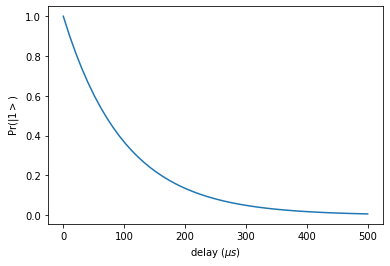

In [13]:
# Solution
t1 = 100e-6
plt.plot(delays * 1e6, inversion_recovery_function(delays * 1e6, t1 * 1e6))
plt.xlabel('delay ($\mu s$)')
plt.ylabel('$\Pr(|1>)$')

In [14]:
from qiskit.result.utils import marginal_counts

from fitting import fit_function


def get_qubit_counts(qubit, result, index):
    """
    Pulse returns the data for all qubits due to triggering constraints
    use this function to trace over unnecessary data.
    """
    return marginal_counts(result.get_counts(index), indices=[qubit.index])


def extract_prob1_data(result, qubit):
    index = qubit.index
    prob_1s = np.zeros(n_exps)
    for exp in range(n_exps):
        counts = get_qubit_counts(qubit, ir_result, exp)
        prob_1 = calc_prob1(counts)
        prob_1s[exp] = prob_1
    return prob_1s


def fit_t1(delays, prob1_data):
    """
    Fit t1 and return with fitted curve data
    """
    fit_params, y_fit = fit_function(
        delays,
        prob1_data, 
        inversion_recovery_function,
        [100],
    )
    return fit_params[0], y_fit

Now we extract the data for each qubit's experiment and fit it to your inversion recovery
function. From this we extract the $T_1$ of the qubit and it to our chip.

The T1 for qubit 0 is 123.5663084059284us
The T1 for qubit 1 is 67.36211534649895us


Text(0.5, 0.98, 'Inversion Recovert Experiment')

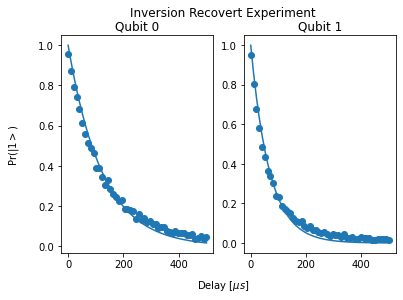

In [15]:
fig, axs = plt.subplots(int(min(np.ceil(len(chip.qubits)/2), 1)), 2)
axs.reshape(-1)

for qubit, ax in zip(chip.qubits, axs):
    prob1_data = extract_prob1_data(ir_result, qubit)
    
    scaled_delays = delays * 1e6
    t1, y_fit = fit_t1(scaled_delays, prob1_data)
    ax.plot(scaled_delays, y_fit)
    ax.scatter(scaled_delays, prob1_data)
    ax.set_title('Qubit {}'.format(qubit.index))
    print("The T1 for qubit {} is {}us".format(qubit.index, t1))
    qubit.attrs.t1 = t1*1e-6 

fig.text(0.5, 0.0, 'Delay [$\mu s$]', ha='center')
fig.text(0.00, 0.5, '$\Pr(|1>)$', va='center', rotation='vertical')
fig.suptitle('Inversion Recovert Experiment')

### Now we have added one more parameter to our knowledge of our device
The $T_1$ helps us upperbound how good a qubit is.

In [16]:
chip

Chip(Qubit(0, attrs={'w0_1': 4968877654.085692, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.08726686228679852, 't1': 0.0001235663084059284}), Qubit(1, attrs={'w0_1': 4770396310.6765375, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.06184223901695044, 't1': 6.736211534649895e-05}))

### If you have extra time, try performing a Ramsey experiment
The [Ramsey experiment](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html#4.-Determining-qubit-Coherence-) is used to find the $T_2^*$ of our qubit, which is how long it will take a state in the $X-Y$ plane on the Bloch sphere, to decay to zero norm when projected onto the $X-Y$ plane. This gives us a sense of how coherent a qubit is.

For a stretch exercise perform a Ramsey experiment and add `t2_star` to our `chip`.